In [ ]:
# Only run this if needed in Colab
!pip install --upgrade gdown

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt


In [ ]:
import gdown

# File IDs from your Google Drive
labels_id = "1kuvHRnoLBjrazWso17-rakg74mzEO0i6"
cnn_data_id = "1rhKR1wH1raDS9xiGCkP9H_lcJoY2htMF"

# Download CSVs
gdown.download(f"https://drive.google.com/uc?id={labels_id}", "labels.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={cnn_data_id}", "cnn_data.csv", quiet=False)

# Load CSVs
cnn_data = pd.read_csv("cnn_data.csv")
labels = pd.read_csv("labels.csv")

cnn_data.head(), labels.head()


Downloading...
From: https://drive.google.com/uc?id=1kuvHRnoLBjrazWso17-rakg74mzEO0i6
To: /content/labels.csv
100%|██████████| 14.1k/14.1k [00:00<00:00, 3.01MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rhKR1wH1raDS9xiGCkP9H_lcJoY2htMF
To: /content/cnn_data.csv
100%|██████████| 82.1k/82.1k [00:00<00:00, 12.4MB/s]


(    0    1    2    3     4   5     6   7     8    9   10    11
 0  22  116  134   14   156  14   116  44    70  132   14   144
 1  22  116  134   14   156  14   116  44    70  132   14   144
 2  14  144   22  116   134  14   156  14   116   44   70   132
 3  14  144   22  116   134  14   156  14   116   44   70   132
 4  98  940  133  902  1204  88  1222  27  1158  872  233  1327,
   composer
 0     Bach
 1     Bach
 2     Bach
 3     Bach
 4     Bach)

In [ ]:
# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels['composer'])

# Normalize inputs and reshape for 1D CNN
X = cnn_data.values.astype('float32')
X /= np.max(X)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Shape: (samples, time_steps, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape}, Test samples: {X_test.shape}")


Training samples: (1539, 12, 1), Test samples: (385, 12, 1)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = dict(enumerate(
    compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
))


In [ ]:
# Define the improved CNN model
model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,268 (169.02 KB)

 Trainable params: 42,628 (166.52 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Setup early stopping
# early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.3178 - loss: 2.1217 - val_accuracy: 0.2675 - val_loss: 1.4012
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3468 - loss: 1.7102 - val_accuracy: 0.2909 - val_loss: 1.4041
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3546 - loss: 1.6001 - val_accuracy: 0.3065 - val_loss: 1.3799
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3893 - loss: 1.5010 - val_accuracy: 0.3584 - val_loss: 1.3563
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3941 - loss: 1.3951 - val_accuracy: 0.3974 - val_loss: 1.2817
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4319 - loss: 1.2985 - val_accuracy: 0.4675 - val_loss: 1.2020
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4254 - loss: 1.3396 - val_accuracy: 0.4961 - val_loss: 1.1246
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4996 - loss: 1.1914 - val_accuracy: 0.5

In [ ]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {accuracy:.2f} | ❌ Loss: {loss:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6931 - loss: 0.7786 
✅ Test Accuracy: 0.68 | ❌ Loss: 0.7957


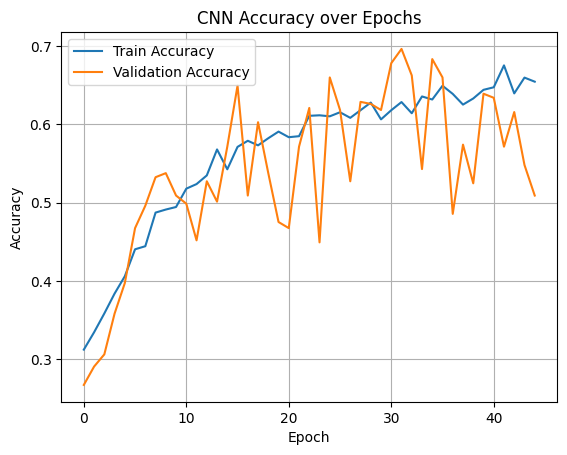

In [ ]:
# Visualize training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
